# Init

In [1]:
%load_ext autoreload
%autoreload 2
from context import rmlib
import rmlib.rmtools as rm



robot = rmlib.robot.Robot( config )

Loaded: /home/nvidia/dev_rmstudio/rmlib/rmlib/rmtools Exists?: True
Loaded: /home/nvidia/dev_rmstudio/rmlib Exists?: True
Setting up robot please wait...
my_components: {'hand_config': {'finger_length': 0.0415, 'finger_depth': 0.014, 'finger_width_outer': 0.015, 'finger_width_inner': 0.0, 'class_name': 'SmartHand', 'module_name': 'hands.smarthand'}, 'arm_config': {'default_linear_accel': 0.8, 'default_joint_speed': 0.7, 'default_joint_accel': 0.8, 'max_joint_accel': 1.4, 'module_name': 'arms.ur5', 'default_linear_speed': 0.1, 'xmlrpc_port': '8003', 'max_linear_accel': 1.2, 'max_linear_speed': 0.25, 'class_name': 'UR5', 'ip_address': '192.168.0.7', 'max_joint_speed': 1.05}, 'ft_config': {'class_name': 'OptoForce', 'ip_address': '192.168.0.3', 'module_name': 'sensors.ftsensor_optoforce'}, 'cam_config': {'class_name': 'RealSense', 'pc_cam_offset': [0, 0, 0], 'ci_cam_offset': [0, 0, 0], 'camera_model': 'd410', 'module_name': 'cameras.realsense'}}
active_componetns: {'arm': ['arm_config'], 

# New Features

# Assembly Testing

In [ ]:
#Imports 
from time import sleep
import numpy as np
import rmlib
from rmlib.rmtools.assembly_trees import augment_RM

augment_RM( robot )

%store -r

####### LIBS #######################################################################################################################################

# Import Pytrees
import py_trees
from py_trees.tests import Timeout_Success
from py_trees.composites import Sequence , Selector


import math
from pmath import translate_pose , get_disance_between_poses , pose_components

from utils import is_matx_list
from math import radians

print( "Libs loaded!" )

## Test Grasp

In [10]:
rootNode = Grasp_at_Pose( fatPegPickPose, 0.020 ,
                            zApproach=0.20, zClose=0.0 , wdthNarrow = 0.059 , maxIter=5, zFree=0.150 , 
                            ctrl = robot )

Created a Sequence with MEMORY!


In [11]:
run_BT_until_done( rootNode , N = 1000 , tickPause = 0.25 , breakOnFailure = 1 , breakOnSuccess = 1 )

Grasp_at_Pose , the sequence was RESET!
Grasp_at_Pose updating ...
Grasp_at_Pose beginning at index 0
Running Move_Arm (after yield), node had status Status.FAILURE
Grasp_at_Pose set own status to Status.FAILURE
Root node Grasp_at_Pose failed!


Simulation completed!




## Test Insert

In [ ]:
# ASMBB.set( "RECORD_KEY" , False )

# rootNode = Sequence( memory = 1 )

rootNode = Sequence_Recorder(  memory = 0 , dataKey = "test_DATA" , flagKey = "test_FLAG" , 
                               outFileGenFunc = get_XML_outfile_namer( pathPrefix = "output/" , namePrefix = "LRG-PEG-TLT_" )  )

recordBehav = Record_Classify( recordFlagKey = "test_FLAG" , dataKey = "test_DATA" , recordHz = 50 , ctrl = robot )


insertTree = Sequence( memory = 1 )

goBehav = Jog_Safe( fatPegPickPose , 
                    zSAFE = 0.100 ,  
                    hover = 1 ,  
                    ctrl  = robot  )

graspBehav = Grasp_at_Pose( fatPegPickPose, 0.020 ,
                            zApproach=0.20, zClose=0.0 , wdthNarrow = 0.059 , maxIter=5, zFree=0.150 , 
                            ctrl = robot )

jogBehav = Jog_Safe( fatPegPreInsertPose , 
                    zSAFE = 0.100 ,  
                    hover = 0 ,  
                    ctrl  = robot  )


tiltBehav = Tilt_Insert( fatPegPreInsertPose ,
                          tilt_angle_deg = 7.25 , part_offset = 0.039 , dia = 0.014 , 
                          touch_force = 0.6 , insert_force = 5.0 , max_movement = 0.045 , biasWrist = 1 , offset_dir = np.array([1.0,0.0,0.0]), 
                          posnMargin = 0.003 , orntMargin = 2.0/180 , finalInsertHandZ = fatPegFullInsertZ , recordFlagKey = "test_FLAG" , ctrl = robot )

dropBehav = Set_Fingers( openState = 1.0 , ctrl = robot )    

insertTree.add_children( [ goBehav , graspBehav , jogBehav , tiltBehav , dropBehav ] )

rootNode.add_children( [ recordBehav , insertTree ] )

In [ ]:
run_BT_until_done( rootNode , N = 1000 , tickPause = 0.25 , breakOnFailure = 1 , breakOnSuccess = 1 )

if 0:
    for elem in ASMBB.get( recordBehav.key ):
        print( elem )
    
print( "Is the q still running?" , recordBehav.workQ.is_running() )

## Output Gear Insert

In [10]:
ASMBB.set( "RECORD_KEY" , False )

from assembly_trees import Spiral_Insert

rootNode = Sequence( memory = 1 )

fingBehav = Set_Fingers( openState = 0.045 , ctrl = robot )

goBehav = Jog_Safe( outGearGraspPose , 
                    zSAFE = 0.100 ,  
                    hover = 0 ,  
                    ctrl  = robot  )

graspBehav = Grasp_at_Pose( outGearGraspPose, 0.035 ,
                            zApproach=0.20, zClose=0.0 , wdthNarrow = 0.045 , maxIter=5, zFree = 0.100 , 
                            ctrl = robot )

jogBehav = Jog_Safe( outGearPreInsertPose , 
                    zSAFE = 0.100 ,  
                    hover = 0 ,  
                    ctrl  = robot  )

insertTree = Sequence( memory = 0 )

recordBehav = Record_Classify( recordFlagKey = "RECORD_KEY" , ctrl = robot )

insertTree.add_child(
    recordBehav
)

insertBehav = Spiral_Insert( outGearPreInsertPose ,
                             touch_force = 1.5 , drop_force = 3 , insert_force = 7 , max_movement = 0.050 , 
                             lateralStopTorque = 1.8 , pushbackF = 20.0 , spiralSpeed = 0.002 , descendSpeed = 0.050 , biasWrist = 1 ,
                             degrees_to_step = 10 , startRadius = 0.001 , stepSize = 0.0005 ,  max_radius=0.060 ,
                             posnMargin = 0.003 , orntMargin = 2.0/180 , finalInsertHandZ = outGearFullInsertZ , ctrl = robot )

insertTree.add_child(
    insertBehav
)


jog2 = Jog_Safe( outGearPreInsertPose , 
                    zSAFE = 0.100 ,  
                    hover = 1 ,  
                    ctrl  = robot  )

dropBehav = Set_Fingers( openState = 0.045 , ctrl = robot )

rootNode.add_children( [ fingBehav , goBehav , graspBehav , jogBehav , insertTree , dropBehav , jog2 ] )

Created a Sequence with MEMORY!
Created a Sequence with MEMORY!
Created a Sequence with MEMORY!
Created a Sequence with MEMORY!
Record_Classify init with data key RECORDING and flag key RECORD_KEY
Created a Sequence with MEMORY!
Created `Store_Current_Pose` with key: lastPose_3
Set_BB_Key initialized with key: RECORD_KEY
Max Spiral Steps: 118
Set_BB_Key initialized with key: RECORD_KEY
Created a Sequence with MEMORY!


In [11]:
run_BT_until_done( rootNode , N = 1000 , tickPause = 0.25 , breakOnFailure = 1 , breakOnSuccess = 1 )

for elem in ASMBB.get( recordBehav.key ):
    print( elem )

Sequence , the sequence was RESET!
Sequence updating ...
Sequence beginning at index 0
Running Set_Fingers (after yield), node had status Status.RUNNING
Sequence set own status to Status.RUNNING
Root node Sequence status: Status.RUNNING
Sequence updating ...
Sequence beginning at index 0
Running Set_Fingers (after yield), node had status Status.RUNNING
Sequence set own status to Status.RUNNING
Root node Sequence status: Status.RUNNING
Sequence updating ...
Sequence beginning at index 0
Running Set_Fingers (after yield), node had status Status.RUNNING
Sequence set own status to Status.RUNNING
Root node Sequence status: Status.RUNNING
Sequence updating ...
Sequence beginning at index 0
Running Set_Fingers (after yield), node had status Status.SUCCESS
Set_Fingers success, index is now 1
Jog_Safe , the sequence was RESET!
0.15
Jog_Safe updating ...
Jog_Safe beginning at index 0
Running Move_Arm (after yield), node had status Status.SUCCESS
Move_Arm has status Status.SUCCESS , Sequence inde

In [8]:
rootNode.terminate( py_trees.common.Status.SUCCESS )

about to TERMINATE
about to WRITE to output/LRG-PEG-TLT_2020-06-17_01-57-25.xml
writing COMPLETE


# Common Functions

In [11]:
robot.hand.grip()

True

In [12]:
robot.hand.release()

False

In [2]:
robot.hand.deactivate_motors()

1

In [15]:
robot.arm.move_to_common_pose('-y')

In [13]:
robot.hand.set_finger_width( 0.045 ) 

True

In [12]:
robot.hand.set_finger_width( 0.000 ) 

True

In [4]:
robot.arm.align_tcp( robot.arm )

True

# Setup

In [13]:
fatPegPickPose = robot.arm.get_tcp_pose()
%store fatPegPickPose

Stored 'fatPegPickPose' (ndarray)


In [2]:
fatPegPreInsertPose = robot.arm.get_tcp_pose()
%store fatPegPreInsertPose

Stored 'fatPegPreInsertPose' (ndarray)


In [13]:
fatPegFullInsertPose = robot.arm.get_tcp_pose()
fatPegFullInsertZ = fatPegFullInsertPose[2,3]
%store fatPegFullInsertPose
%store fatPegFullInsertZ

Stored 'fatPegFullInsertPose' (ndarray)
Stored 'fatPegFullInsertZ' (float64)


In [11]:
outGearGraspPose = robot.arm.get_tcp_pose()
%store outGearGraspPose

Stored 'outGearGraspPose' (ndarray)


In [13]:
outGearPreInsertPose = robot.arm.get_tcp_pose()
%store outGearPreInsertPose

Stored 'outGearPreInsertPose' (ndarray)


In [8]:
outGearFullInsertPose = robot.arm.get_tcp_pose()
outGearFullInsertZ = outGearFullInsertPose[2,3]
%store outGearFullInsertPose
%store outGearFullInsertZ

Stored 'outGearFullInsertPose' (ndarray)
Stored 'outGearFullInsertZ' (float64)


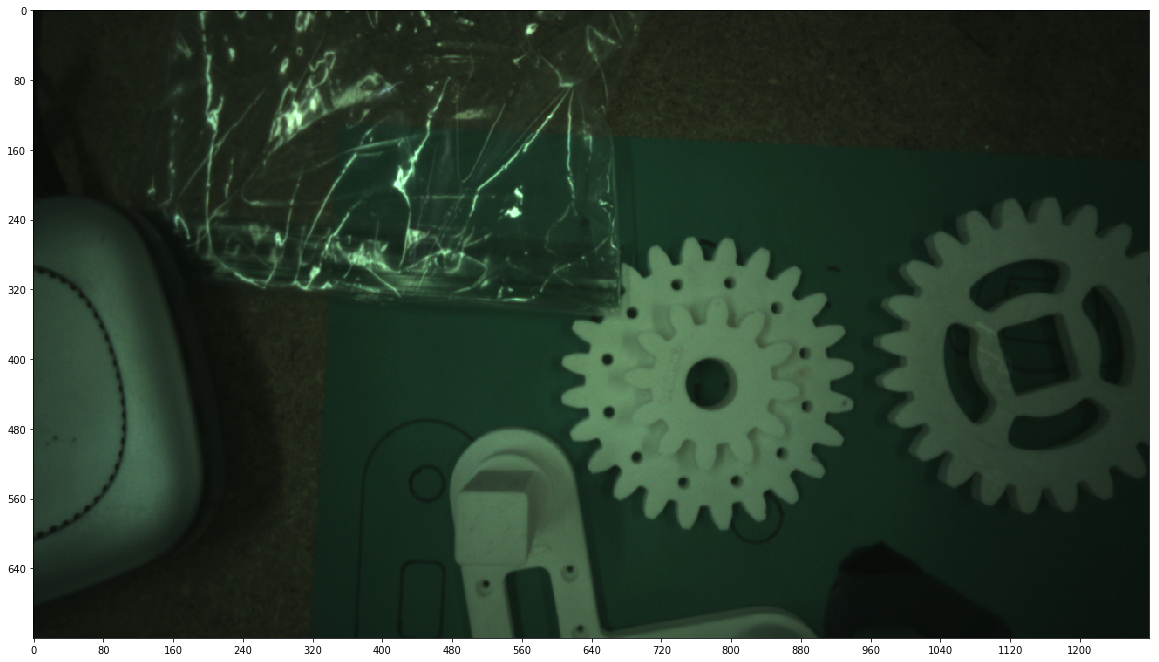

In [3]:
img = robot.camera.get_color_image()
rm.viewer.show_image(img)

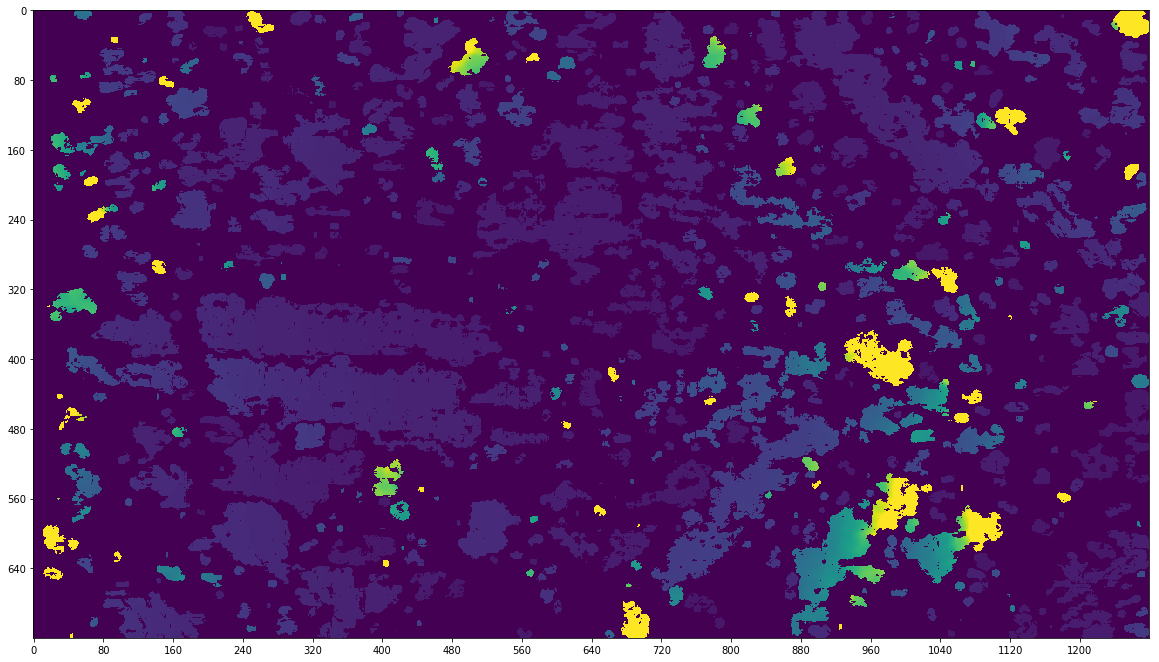

In [4]:
img = robot.camera.get_depth_image()
rm.viewer.show_image( img )

Note: UR box must be powered on before the arm can be

In [3]:
robot.arm.power_on()

In [4]:
robot.arm.brake_release()

In [5]:
robot.arm.get_tcp_pose()

array([[-0.99999673, -0.00140518,  0.00213716, -0.11120885],
       [-0.00135358,  0.99971208,  0.02395689, -0.48375368],
       [-0.00217021,  0.02395392, -0.99971071,  0.15019056],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [6]:
robot.arm.translate_tcp([0,0,0.01])

In [7]:
robot.arm.move_to_common_pose('-y')

In [8]:
robot.ft_sensor.bias_wrist_force()

b'{"result":0,"error":"","response":{"id":"bias"}}\r\n\r\n'

In [9]:
robot.ft_sensor.get_wrist_force()

[0.0, 0.0, 0.0, 0.0004999637603759766, 0.001000046730041504, 0.0]

In [10]:
robot.hand.grip()

False

In [11]:
robot.hand.release()

False